In [1]:
import jax.numpy as jnp
from jax.random import key, normal
from ppptm.util.locs import unit_grid_vars
import tensorflow_probability.substrates.jax.math.psd_kernels as tfk
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb
import pandas as pd
import plotnine as p9
import jax
import liesel.model as lsl
from ppptm.model2 import Model

jax.config.update("jax_enable_x64", True)

ImportError: cannot import name 'PseudoTransformationDist' from 'liesel_ptm.dist' (/Users/johannesbrachem/Documents/git/ppptm/.venv/lib/python3.13/site-packages/liesel_ptm/dist.py)

In [137]:
locs = unit_grid_vars(ngrid=40, n_subset=100)

loc = lsl.Var.new_param(jnp.array(0.0), name="loc")
scale = lsl.Var.new_param(jnp.array(1.0), name="scale")
scale.transform(tfb.Softplus())
response = normal(key(123), (locs.locs.nloc, 203))

model = Model.new_HG(
    y=response,
    a=-6.0,
    b=6.0,
    inducing_locs=locs.ordered_subset,
    sample_locs=locs.ordered,
    kernel_cls=tfk.MaternFiveHalves,
    G=tfd.Normal,
    loc=loc,
    D=30,
    scale=scale,
    locscale=True,
    amplitude=jnp.array(0.05),
    length_scale=jnp.array([0.1, 0.4]),
)

In [143]:
coef_samples = model.coef.latent_var.sample((1,), seed=key(1))
coef_samples["coef_latent"] = coef_samples["coef_latent"][0, ...]

In [144]:
coef_samples["coef_latent"].shape

(3000,)

In [145]:
model.coef.latent_var.value = coef_samples["coef_latent"]
y = model.sample(4, seed=key(4))

In [146]:
df = pd.DataFrame(y).reset_index(names="loc")
df["lon"] = locs.ordered.value[:, 0]
df["lat"] = locs.ordered.value[:, 1]
df = df.melt(id_vars=["loc", "lon", "lat"], var_name="obs")
df

,loc,lon,lat,obs,value
0,0,0.512821,0.512821,0,0.117462
1,1,0.000000,0.000000,0,4.083482
2,2,0.000000,1.000000,0,-5.140147
3,3,1.000000,0.000000,0,-4.668611
4,4,1.000000,1.000000,0,-4.210285
...,...,...,...,...,...
6395,1595,0.974359,0.743590,3,-4.797034
6396,1596,0.974359,0.897436,3,-4.511582
6397,1597,1.000000,0.615385,3,-5.013922
6398,1598,1.000000,0.769231,3,-5.062793


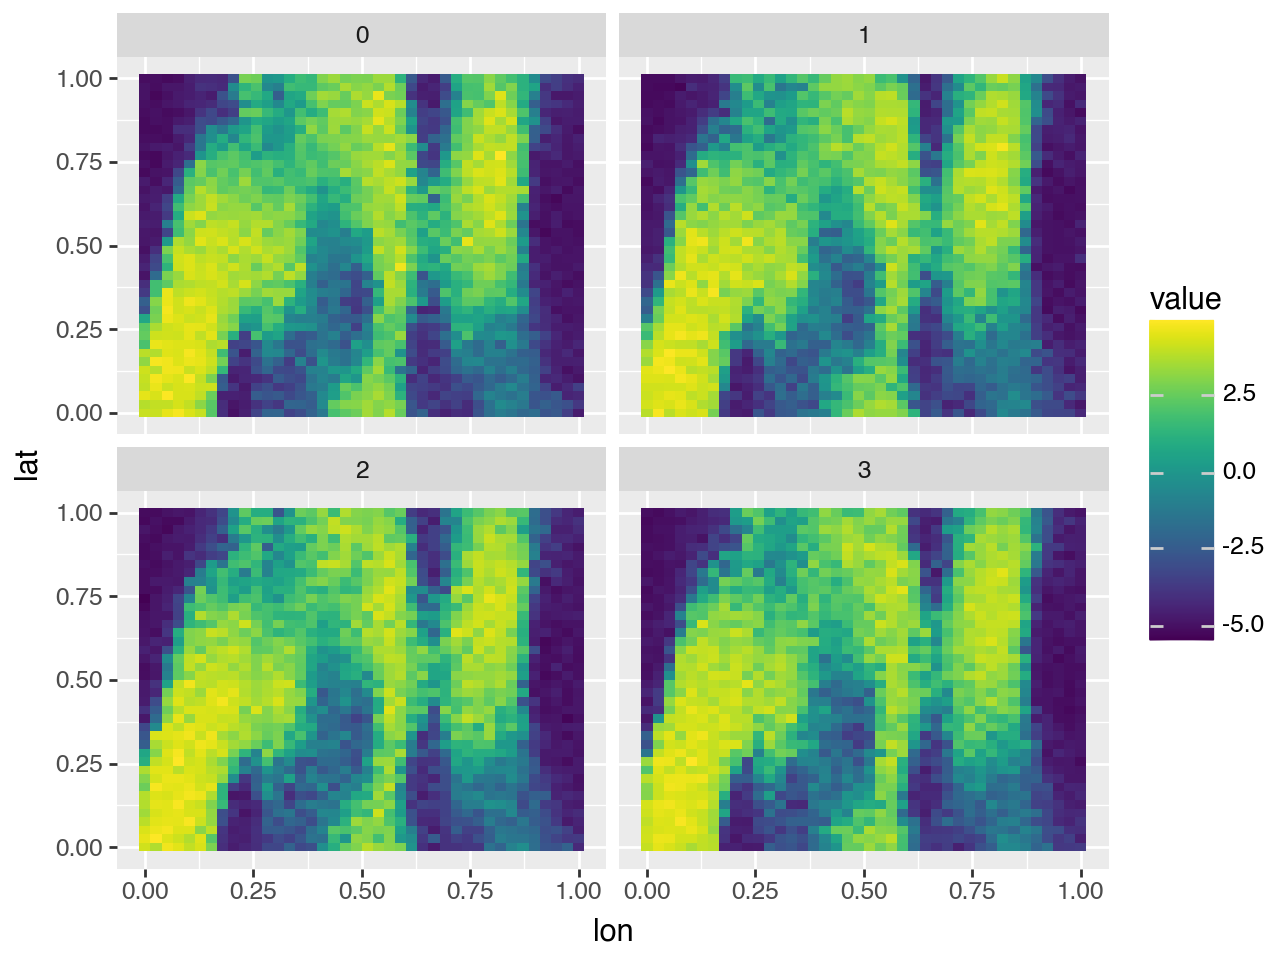

In [147]:
(
    p9.ggplot(df)
    + p9.geom_tile(p9.aes("lon", "lat", fill="value"))
    + p9.facet_wrap("~obs")
)